In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, concatenate, Flatten, CuDNNGRU, Conv1D
from keras.layers import GRU, SpatialDropout1D, Flatten, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from gensim.models.keyedvectors import KeyedVectors

import tensorflow as tf
import os

In [ ]:
#data_type = {"negatif": np.float64, "netral": np.float64, "positif": np.float64}
#data_type = {"senang": np.float64, "sedih": np.float64, "kecewa": np.float64, "bingung": np.float64, "cinta": np.float64}
data_type = {"ekonomi": np.float64, "fisik_tampilan": np.float64, "emosi": np.float64, "ekonomi": np.float64, "performa": np.float64, "layanan":np.float64}

In [ ]:
#, header= None, names=['Comment','ekonomi','emosi','performa','fisik_tampilan','layanan','aspek']
data = pd.read_csv('drive/MyDrive/TA/newera/aspekmax.csv', dtype=data_type)
data_test = pd.read_csv('drive/MyDrive/TA/newera/dataval.csv', dtype=data_type)
data = data.dropna()
data_test = data_test.dropna()
data.Comment = data.Comment.astype(str)
data_test.Comment = data_test.Comment.astype(str)

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)
data

,Unnamed: 0,Unnamed: 0.1,Comment,negatif,netral,positif,ekonomi,emosi,performa,fisik_tampilan,layanan,polaritas,aspek
0,1430,612,sama banget gue dari rumah udah niat beli bodo...,0,0,1,0.0,0.0,0.0,0.0,1.0,positif,layanan
1,2579,590,diembargo maskapai hong kong airlines,1,0,0,0.0,0.0,0.0,0.0,1.0,negatif,layanan
2,295,897,emang gak bisa gue gak pakai tapi memang gak b...,1,0,0,1.0,0.0,0.0,0.0,0.0,negatif,ekonomi
3,1,1482,iya emang keren banget ini paling kurang kamer...,0,0,1,0.0,0.0,1.0,0.0,0.0,positif,performa
4,1880,2073,semoga berikan xiomi black shark 3 buat gantii...,0,1,0,0.0,1.0,0.0,0.0,0.0,netral,emosi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5154,2040,2488,eunbi rl hpnya 11 red kalau hsw apa ya,0,1,0,0.0,0.0,0.0,1.0,0.0,netral,fisik_tampilan
5155,357,2857,kita kan dulu nyesel gasi pas series keluar wa...,0,1,0,0.0,0.0,0.0,1.0,0.0,netral,fisik_tampilan
5156,2595,643,kamera cahaya lembut,0,0,1,0.0,0.0,1.0,0.0,0.0,positif,performa
5157,2154,481,tapi dah habis stock rasanya,1,0,0,0.0,1.0,0.0,0.0,0.0,negatif,emosi


In [ ]:
#label = ['negatif', 'netral', 'positif']
#label = ['bingung', 'cinta', 'kecewa', 'sedih', 'senang']
label = ['ekonomi', 'emosi', 'fisik_tampilan', 'layanan', 'performa']
y_train = data[label].values
y_test = data_test[label].values
list_sentences_train = data["Comment"]
list_sentences_test = data_test["Comment"]
list_sentences_test

0      kejar kamera kalau jenis gaming kalau tak kisa...
1      lagi nyari warna ungu trus tetiba keinget kalo...
2      udah pernah pake soalnya kurleb 5 tahun jadi g...
3                             semakin depan bismillah f3
4      5 sebab mengapa f3 5g antara peranti terbaik p...
                             ...                        
287                         bingung mending x3 atau huft
288    iyak ni seri nya dari deh keknya tapi emang sp...
289                          sepupu ku pake 11 bagus kok
290    ada pakai max dah update ke 146 and kamera dep...
291                              semoga dapat hadiah ini
Name: Comment, Length: 292, dtype: object

In [ ]:
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder()
y_test2 = le.fit(data['aspek'])
le.classes_

array(['ekonomi', 'emosi', 'fisik_tampilan', 'layanan', 'performa'],
      dtype=object)

In [ ]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
tokenizer.fit_on_texts(list(list_sentences_test))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_test[1]

[40,
 306,
 216,
 437,
 126,
 3800,
 6128,
 4,
 1,
 117,
 429,
 216,
 437,
 13,
 11,
 1998,
 977,
 2010,
 48,
 747,
 15,
 6129,
 82,
 6130,
 11,
 2343,
 15,
 29,
 2837,
 7,
 90,
 3385]

In [ ]:
list_sentences_test[1]

'lagi nyari warna ungu trus tetiba keinget kalo ada seri s warna ungu nya sama oiya s20 fe pas cek harga secondnya sekarang omegaat sama ma harga baru saatnya ga nih gaes'

In [ ]:
maxlen = 50
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
X_train

array([[   0,    0,    0, ...,   47,  135,  361],
       [   0,    0,    0, ...,  370,  371,  809],
       [   0,    0,    0, ...,  485,   17, 2057],
       ...,
       [   0,    0,    0, ...,   28, 2338,  710],
       [   0,    0,    0, ...,  502,  672, 1103],
       [   0,    0,    0, ...,  218,  165,  884]], dtype=int32)

In [ ]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [ ]:
#Loading pre-trained embeddings
print("loading word2vec...")
# start = time.time()
word_vectors = KeyedVectors.load_word2vec_format("drive/MyDrive/TA/modelapik.bin",
                                                 binary="True", unicode_errors='ignore')
# end = time.time()
# print("word2vec loading done in {} seconds".format(end-start))

word2vec = word_vectors
embed_dim = 300

loading word2vec...


In [ ]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

5844 745
known words: 5844
unknown words: 745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
emb_init_values.shape

(6590, 300)

In [ ]:
emb_init_values

array([[ 0.09057077, -0.13211627, -0.07370127, ...,  0.01723903,
        -0.01558329,  0.23495317],
       [ 0.23018308,  0.36727202,  0.02258815, ..., -0.08636202,
         0.10429382,  0.01294505],
       [ 0.16070516, -0.00104823, -0.03247326, ..., -0.02509324,
        -0.014336  ,  0.13993736],
       ...,
       [ 0.05195912,  0.07651727, -0.5153454 , ..., -0.58588165,
         0.6745723 ,  0.36162528],
       [ 0.10345185, -0.4586435 , -0.26562354, ..., -0.21579528,
         0.17864285,  0.6146071 ],
       [-0.18348247,  0.2084816 ,  0.15202554, ...,  0.02773641,
        -0.01960012, -0.04912846]], dtype=float32)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
vocab_size=len(tokenizer.word_index)+1
embedding_dim = 300
num_filters = 256
kernel_size = 12
batch_size = 10

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,weights=[emb_init_values], input_length=maxlen, trainable = False))
model.add(layers.Conv1D(num_filters, kernel_size, padding ="same",activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.005))
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_split=0.1,
                    callbacks=callbacks,
                    batch_size=batch_size)

In [ ]:
history.history['val_accuracy']

[0.8527131676673889,
 0.8914728760719299,
 0.9011628031730652,
 0.9011628031730652,
 0.8972868323326111,
 0.9031007885932922,
 0.8856589198112488,
 0.895348846912384,
 0.8972868323326111,
 0.8972868323326111,
 0.8972868323326111]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           1977000   
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 256)           921856    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 35)                8995      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 180       
Total params: 2,908,031
Trainable params: 931,031
Non-trainable params: 1,977,000
________________________________________

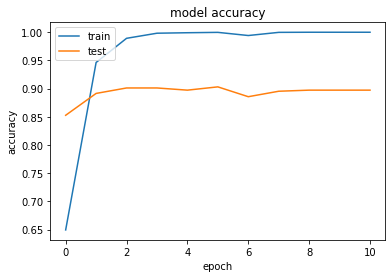

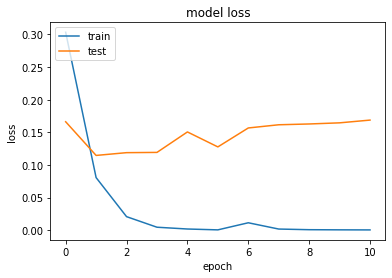

In [ ]:
print(model.summary())
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy  : {:.4f}".format(accuracy))
#loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
#print("Testing Accuracy   : {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))

Training Accuracy  : 0.9897
Validation Accuracy: 0.5616


In [ ]:
model.evaluate(X_test, y_test, verbose=None)

[0.7413987517356873, 0.5616438388824463]

In [ ]:
y_pred = model.predict([X_test], batch_size=batch_size, verbose=False)
y_pred

array([[8.5887527e-01, 9.5694733e-05, 2.0744809e-04, 6.0834054e-07,
        1.4082099e-01],
       [1.1495676e-01, 1.1777706e-05, 8.8001442e-01, 4.9972761e-04,
        4.5171976e-03],
       [4.2294912e-02, 6.7093354e-01, 2.7091315e-01, 1.2288269e-06,
        1.5857130e-02],
       ...,
       [2.4147738e-07, 9.9996591e-01, 9.1580487e-06, 2.8206402e-09,
        2.4702877e-05],
       [1.4442452e-06, 2.2269815e-05, 1.0892173e-06, 7.1523928e-08,
        9.9997509e-01],
       [1.6838585e-05, 9.9882859e-01, 1.6938266e-05, 6.8401282e-06,
        1.1308676e-03]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
polar = le.transform(data_test['aspek'])
#polar = np.array(polar.astype(str).values)
polar

array([4, 2, 1, 1, 4, 2, 4, 0, 1, 4, 0, 0, 4, 1, 1, 1, 1, 1, 1, 4, 0, 1,
       4, 0, 2, 1, 2, 0, 1, 1, 4, 4, 3, 1, 1, 4, 2, 4, 3, 4, 0, 3, 4, 4,
       4, 1, 4, 1, 1, 1, 1, 4, 4, 1, 4, 3, 2, 1, 3, 4, 2, 1, 1, 4, 1, 4,
       3, 0, 0, 1, 4, 4, 1, 1, 0, 4, 1, 1, 1, 3, 0, 4, 4, 2, 2, 1, 1, 1,
       0, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 3, 1, 1, 1, 2, 0, 0, 1, 0, 4, 0,
       0, 1, 3, 0, 4, 4, 1, 1, 0, 1, 1, 1, 4, 4, 1, 1, 0, 4, 4, 1, 1, 1,
       4, 4, 1, 4, 1, 4, 1, 1, 4, 4, 4, 2, 1, 4, 1, 1, 1, 1, 0, 1, 3, 1,
       4, 4, 1, 1, 4, 4, 4, 1, 1, 2, 1, 1, 4, 4, 1, 1, 4, 0, 4, 2, 2, 1,
       3, 1, 4, 1, 1, 1, 1, 2, 0, 4, 0, 0, 2, 4, 4, 1, 1, 1, 1, 1, 4, 1,
       1, 2, 1, 1, 1, 4, 1, 2, 1, 4, 0, 4, 4, 4, 4, 1, 4, 0, 2, 3, 0, 0,
       1, 1, 1, 4, 1, 1, 4, 4, 2, 3, 1, 4, 4, 2, 4, 1, 1, 4, 0, 4, 2, 0,
       4, 1, 1, 1, 0, 4, 1, 1, 4, 4, 2, 4, 1, 4, 1, 1, 2, 1, 1, 1, 4, 1,
       4, 4, 1, 3, 1, 0, 0, 1, 1, 1, 4, 3, 1, 0, 4, 4, 1, 2, 2, 0, 1, 1,
       1, 1, 0, 4, 4, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, polar)
cm

array([[ 12,   1,   1,   1,   8],
       [ 18, 106,  19,   9,  38],
       [  1,   2,   1,   2,   2],
       [  0,   0,   0,   0,   0],
       [  6,  12,   5,   3,  45]])

In [ ]:
report = classification_report(y_pred, polar, output_dict=True)
report = pd.DataFrame(report)
report = report.transpose()
report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.324324,0.521739,0.400000,23.000000
1,0.876033,0.557895,0.681672,190.000000
2,0.038462,0.125000,0.058824,8.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.483871,0.633803,0.548780,71.000000
accuracy,0.561644,0.561644,0.561644,0.561644
macro avg,0.344538,0.367687,0.337855,292.000000
weighted avg,0.714275,0.561644,0.610109,292.000000


In [ ]:
import seaborn as sns

In [ ]:
def ConfusionMatrix(y_pred_class, sentimen_val):
    # Compute and plot the Confusion matrix
    #cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['ekonomi', 'emosi', 'fisik_tampilan', 'layanan', 'performa']
    #categories  = ['negatif', 'netral', 'positif']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, annot = True, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

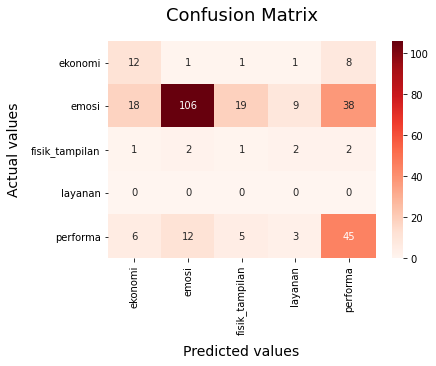

In [ ]:
ConfusionMatrix(y_pred, polar)